In [2]:
from Assignment_Queries.pandas_lib.std_imports import *
from Assignment_Queries.pandas_lib.func_lib import *
from Server_Cleaning.modules.Assignment_datasets import *
path = '../'

# Introduction
In this document, we want to perform analyses that provide information about **football clubs**. 
We will pay particular attention to the average goals scored/conceded.
Furthermore, we will focus on one club (of our choice) and analyse it.

In [3]:
# Getting and cleaning the DataFrames
clubs = clear_clubs(get_clubs(path))
club_games = clear_club_games(get_club_games(path))
games = clear_games(get_games(path))
game_events = clear_game_events(get_game_events(path))

# Formations:
We can start seeing some numbers about the most used formation and the way they bring to victories or losses.

In [8]:
top_formations = games.value_counts('home_club_formation').sort_values(ascending=False).head(10)
# Finding games data about this formations
top_10_f_games = (games[games['home_club_formation']
    .isin(top_formations.index)][['home_club_id', 'aggregate', 'home_club_formation']])
top_10_f_games['aggregate'] = (top_10_f_games['aggregate'].apply(lambda x: check_home_win(x)))
# Dividing df by aggregate results
win_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'win'].value_counts('home_club_formation')).rename(columns={'count': 'won'})
loss_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'loss'].value_counts('home_club_formation')).rename(columns={'count': 'loss'})
draw_df = pd.DataFrame(top_10_f_games[top_10_f_games['aggregate'] == 'draw'].value_counts('home_club_formation')).rename(columns={'count': 'draw'})
# Joining and plotting
df = win_df.join(draw_df).join(loss_df)

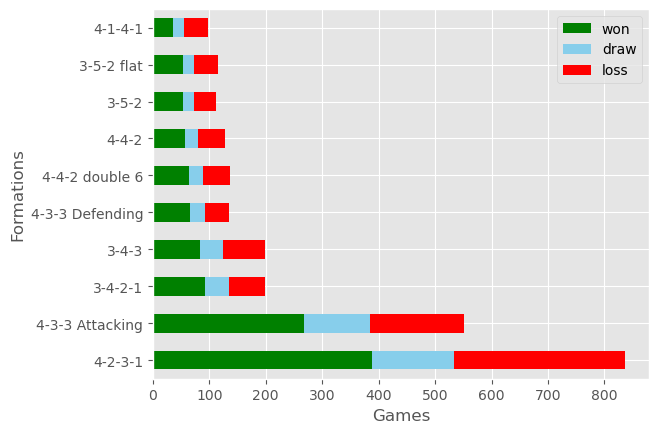

In [9]:
df.plot(kind='barh', stacked=True, color=['green', 'skyblue', 'red'])
plt.xlabel('Games')
plt.ylabel('Formations')
plt.show()

# What do we see?
We can see that the ratio between victories, losses and draw remains almost ever the same throughout all our dataset.
<br>
# And now?
We would like to see **how different formations behave** when deployed against each other.

In [6]:
# We create a DataFrame to inspect data about formation combinations 
format_compare_df = (games.groupby(['home_club_formation', 'away_club_formation'], as_index=False).agg(
    home_avg_goals=pd.NamedAgg(column='home_club_goals', aggfunc='mean'),
    away_avg_goals=pd.NamedAgg(column='away_club_goals', aggfunc='mean'))
                     .rename(columns={'home_club_formation': 'home_formation', 'away_club_formation': 'away_formation'}))
# Adding 'count' column
format_compare_df = format_compare_df.join(games.value_counts(['home_club_formation', 'away_club_formation']), on=['home_formation', 'away_formation'])
# We set the mean of the count as minimum threshold for the data to analyze
format_compare_df = format_compare_df[format_compare_df['count'] > np.mean(format_compare_df['count'])]
format_compare_df['diff']  = format_compare_df['home_avg_goals'] - format_compare_df['away_avg_goals']
# Creating a pivot to display a heatmap 
heatmap_data = format_compare_df[['home_formation', 'away_formation', 'diff']].pivot(index='home_formation', columns='away_formation', values='diff')

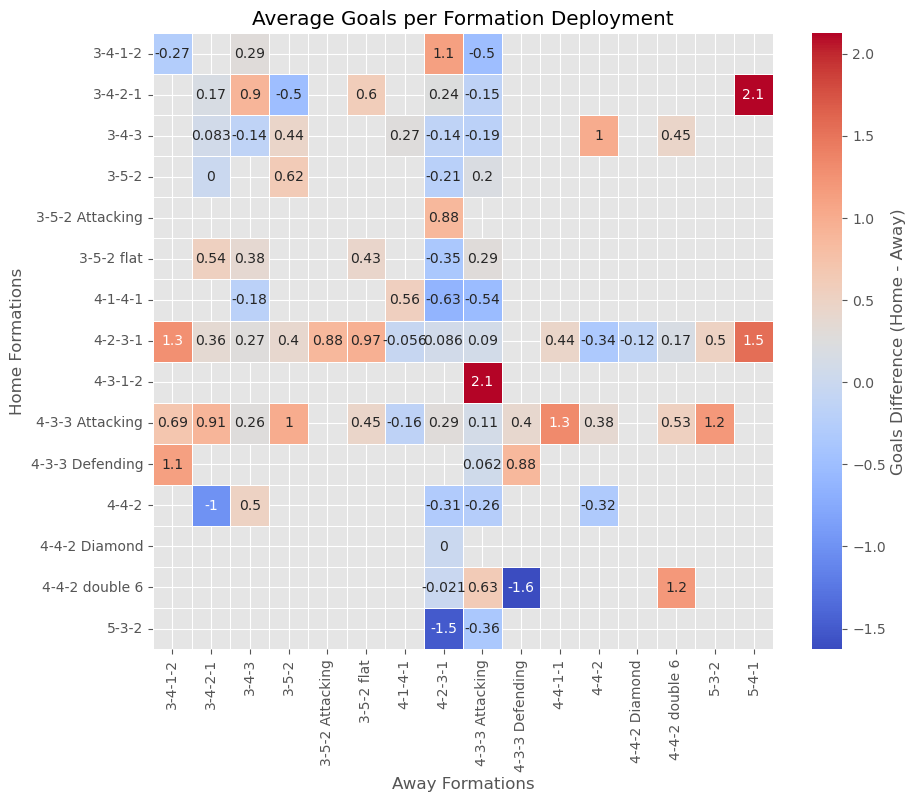

In [7]:
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', linewidths=0.5, cbar_kws={'label': 'Goals Difference (Home - Away)'})
plt.title('Average Goals per Formation Deployment')
plt.xlabel('Away Formations')
plt.ylabel('Home Formations')
plt.show()

# Observations:
1. We can see that combinations as **"4-2-3-1"** vs **"4-4-2 double 6"** converge to _0_ _(here 0.17)_ after just 35 matches played.
2. On the other hand, formation **"5-4-1"** tends to be more effective against formations **"4-2-3-1"** and **"3-4-2-1"**, as we can see from the graph which shows us an average of 1.5 and 2 more goals respectively. _(In this case we must point out that there is not much data to work with)_
3. Finally, we focus on data about the formation **"5-3-2"**